# Seasonal Repeat Analysis
Assess the variability and consistency of activity phenotypes, with the purpose of determining practicality for use as diagnostics

In [130]:
%matplotlib notebook
import scipy
import numpy
from IPython.display import display, HTML
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import re
import matplotlib.patches as mpatches
from scipy.cluster import hierarchy
import pylab
import pandas

In [131]:
N_ITER = 100
DDOF = 1 # ddof for the var() function
OUTDIR = "../phewas/seasonal/"

In [132]:
# Original activity data
full_activity = pandas.read_csv("../processed/activity_features_aggregate.txt", index_col=0, sep="\t")
full_activity_summary = pandas.read_csv("../processed/activity_summary_aggregate.txt", index_col=0, sep="\t")

ukbb = pandas.read_hdf("../processed/ukbb_data_table.h5")

c:\users\tgb\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (816) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [133]:
# Load seasonal repeat data
full_activity_seasonal = pandas.read_csv("../processed/activity_features_aggregate_seasonal.txt", index_col=0, sep="\t")
id_instance = pandas.Series(full_activity_seasonal.index).astype(str).str.split(".", expand=True)
full_activity_seasonal["id"] = id_instance[0].values
full_activity_seasonal["instance"] = id_instance[1].values


full_activity_summary_seasonal = pandas.read_csv("../processed/activity_summary_aggregate_seasonal.txt", index_col=0, sep="\t")
id_instance = pandas.Series(full_activity_summary_seasonal.index).astype(str).str.split(".", expand=True)
full_activity_summary_seasonal["id"] = id_instance[0].values
full_activity_summary_seasonal["instance"] = id_instance[1].values

In [134]:
full_activity_seasonal.describe().T

,count,mean,std,min,25%,50%,75%,max
main_sleep_onset_mean,109973.0,23.468223,1.181336,12.059372,22.819861,23.396900,24.037151,35.775857
main_sleep_offset_mean,109973.0,31.618350,1.482982,15.331099,31.023102,31.607928,32.178239,177.993543
num_wakings_mean,109973.0,1.261570,1.088273,0.000000,0.571429,1.000000,1.714286,26.571429
WASO_mean,109973.0,0.211077,0.197600,0.000000,0.069048,0.156667,0.293333,1.983333
acceleration_during_main_sleep_mean,109973.0,3.065951,6.468282,0.000000,2.749012,2.995456,3.283363,2124.902312
...,...,...,...,...,...,...,...,...
VPA_within_day_SD_L5,111989.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
VPA_between_day_SD_L5,112021.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
VPA_RA,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VPA_IS,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [135]:
# drop activity for people who fail basic QC
[c for c in full_activity_summary.columns if 'quality' in c]
okay = (full_activity_summary['quality-goodCalibration'].astype(bool)
            & (~full_activity_summary['quality-daylightSavingsCrossover'].astype(bool))
            & (full_activity_summary['quality-goodWearTime'].astype(bool))
       )
activity = full_activity[okay].copy()
activity_summary = full_activity_summary[okay].copy()
activity.columns = activity.columns.str.replace("-","_") # Can't use special characters easily
print(f"Dropping {(~okay).sum()} entries out of {len(okay)} due to bad quality or wear-time in their activity")

okay = (full_activity_summary_seasonal['quality-goodCalibration'].astype(bool)
            & (~full_activity_summary_seasonal['quality-daylightSavingsCrossover'].astype(bool))
            & (full_activity_summary_seasonal['quality-goodWearTime'].astype(bool))
       )
activity_seasonal = full_activity_seasonal[full_activity_seasonal.index.isin(okay.index[okay])].copy()
activity_summary_seasonal = full_activity_summary_seasonal[full_activity_summary_seasonal.index.isin(okay.index[okay])].copy()
activity_seasonal.columns = activity_seasonal.columns.str.replace("-","_") # Can't use special characters easily
print(f"Dropping {(~okay).sum()} entries out of {len(okay)} due to bad quality or wear-time in their SEASONAL activity")


c:\users\tgb\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


Dropping 11363 entries out of 103688 due to bad quality or wear-time in their activity
Dropping 1675 entries out of 11773 due to bad quality or wear-time in their SEASONAL activity


In [136]:
### Drop columns that are meaningless
# if standard deviation is 0 or NaN, then no variation and we drop it
# or if the standard deviation is less than 1% of the mean value
std = activity_seasonal.std(axis=0)
mean = activity_seasonal.select_dtypes(["number"]).mean(axis=0).abs()
bad_std_columns = (std == 0) | (std.isna()) | (std[mean.index] < 0.01 * mean )

# check columns with too many duplicates: if min = median or max = median, than too many people have the same value
# and we just drop the column
too_many_duplicates_columns = (activity_seasonal.min(axis=0) == activity_seasonal.median(axis=0)) | (activity_seasonal.max(axis=0) == activity_seasonal.median(axis=0))
columns_to_drop = bad_std_columns[bad_std_columns].index.union(too_many_duplicates_columns[too_many_duplicates_columns].index)
columns_to_drop
activity_seasonal.drop(columns=columns_to_drop, inplace=True)
print(f"Dropping {len(columns_to_drop)} due to extremely low variation between individuals")
print(f"Have {len(activity_seasonal.columns)} activity variables remaining")

c:\users\tgb\appdata\local\programs\python\python36\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Dropping 43 due to extremely low variation between individuals
Have 213 activity variables remaining


In [137]:
# First check for outliers in each column
# By the ratio of the standard deviation to the median absolute deviation
# In a normally distributed variable, this will be about 1.48
outlier_ratio = numpy.maximum(activity.std() / activity.mad(), activity_seasonal.std() / activity_seasonal.mad())
#outlier_ratio.sort_values(ascending=False).head(25)


# Take the 'bad' columns, those beyond the cutoff
OUTLIER_RATIO_CUTOFF = 4
STD_OUTLIER_CUTOFF = 10
outlier_data = activity.loc[:, outlier_ratio > OUTLIER_RATIO_CUTOFF]
is_outlier = (((outlier_data - outlier_data.mean()) / outlier_data.std()) > STD_OUTLIER_CUTOFF)
num_outliers = is_outlier.sum()
total_outliers = is_outlier.any(axis=1).sum()
to_drop = activity.index[is_outlier.any(axis=1)]
activity.drop(index=to_drop, inplace=True)
activity_summary.drop(index=to_drop, inplace=True)
print(f"Found {len(outlier_data.columns)} columns with evidence of some outlier problems")
print(f"Dropping {total_outliers} subjects with one of those columns beyond {STD_OUTLIER_CUTOFF} standard deviations from mean")

# Again for seasonal data
outlier_data = activity_seasonal.loc[:, outlier_data.columns]
is_outlier = (((outlier_data - outlier_data.mean()) / outlier_data.std()) > STD_OUTLIER_CUTOFF)
num_outliers = is_outlier.sum()
total_outliers = is_outlier.any(axis=1).sum()
to_drop = activity_seasonal.index[is_outlier.any(axis=1)]
activity_seasonal.drop(index=to_drop, inplace=True)
activity_summary_seasonal.drop(index=to_drop, inplace=True)
print(f"Dropping {total_outliers} subjects with one of those columns beyond {STD_OUTLIER_CUTOFF} standard deviations from mean from SEASONAL data")


Found 3 columns with evidence of some outlier problems
Dropping 288 subjects with one of those columns beyond 10 standard deviations from mean
Dropping 35 subjects with one of those columns beyond 10 standard deviations from mean from SEASONAL data


In [139]:
ZSCORE_OUTLIER_CUTOFF = 7

# Drop out the extreme outliers in the dataset
# First remove all infinities as NaNs - shouldn't be many anyway
infs = ~numpy.isfinite(activity.values)
activity.iloc[infs] = float("NaN")
stds = activity.std()
means = activity.mean()
zscores = ((activity - means) / stds).abs()
outlier = zscores > ZSCORE_OUTLIER_CUTOFF
num_outliers = outlier.sum().sum()
pct_outliers = num_outliers / len(zscores.values.flatten())
print(f"Identified and removed {num_outliers} ({pct_outliers:0.3%}) outlier measurements")
activity[outlier] = float("Nan")

Identified and removed 9428 (0.106%) outlier measurements


In [143]:
print(f"Remaining {len(activity_seasonal.index)} entries across {len(activity_seasonal['id'].unique())} individuals")
pct_missing = activity.isna().sum().sum() / len(activity.values.flatten())
print(f"Total of {pct_missing:0.3%} of all datapoints are missing")

Remaining 10061 entries across 3151 individuals
Total of 0.150% of all datapoints are missing


In [146]:
# Generate processed columns
# Make phase unimodal by moving it to 0-24 hours
activity_seasonal['phase'] = (activity_seasonal.phase) % 24
activity_seasonal['temp_phase'] = activity_seasonal.temp_phase % 24

## Intra- versus inter-personal variance

In [147]:
# Determine intra-personal variability relative to inter-personal variability
def SSE(data):
    return ((data - data.mean())**2).sum()
#inter_personal = SSE(activity_seasonal.groupby("id").mean())
#intra_personal = activity_seasonal.select_dtypes("number").groupby(activity_seasonal.id).apply(SSE).sum()
#total_var = SSE(activity_seasonal.select_dtypes("number"))
inter_personal = activity_seasonal.groupby("id").mean().var()
intra_personal = activity_seasonal.groupby("id").var().mean()
total_var = activity_seasonal.var()
intra_personal_normalized = intra_personal / inter_personal

# Variability in variance proportion
#intra_personal_normalized_samples = []
#for i in range(N_ITER):
#    sample = activity_seasonal.sample(len(activity_seasonal), replace=True)
#    intra_personal_normalized_samples.append(sample.groupby("id").var().mean() / sample.var())
#intra_personal_normalized_samples = pandas.concat(intra_personal_normalized_samples, axis=1)

In [148]:
# Compute the inter/intra variability for phase variables separately
# Need to account for the 'wrap-around' at 24 hours
# We use scipy.stat's circvar and circmean for this
phase_var_markers = ['phase', 'time_mean', 'L1_time', 'L1_median_time', 'M10_time', 'L5_time', 'offset_mean', 'onset_mean']
phase_variables = [c for c in activity_seasonal.columns
                     if any((v in c) for v in phase_var_markers)]
a = None
def circvar(df):
    # Take circular variance of each column
    #print(df)
    if len(df) - DDOF == 0:
        return float("NaN")
    return df.apply(scipy.stats.circvar, nan_policy="omit", high=24) * len(df) / (len(df) - DDOF)
def circmean(df):
    # Take circular mean of each column
    return df.apply(scipy.stats.circmean, nan_policy="omit", high=24)
def groupby_apply(grouper, func, **kwargs):
    # For some reason, pandas's groupby().apply() function breaks on our data, implement manually
    res = {}
    for key, group in grouper:
        res[key] = func(group, **kwargs)
    return pandas.DataFrame(res).T



inter_personal[phase_variables] = circvar(groupby_apply(activity_seasonal[phase_variables].groupby(activity_seasonal.id), circmean))
intra_personal[phase_variables] = (groupby_apply(activity_seasonal[phase_variables].groupby(activity_seasonal.id), circvar)).mean()
total_var[phase_variables] = circvar(activity_seasonal[phase_variables])
intra_personal_normalized = intra_personal / inter_personal

<IPython.core.display.Javascript object>


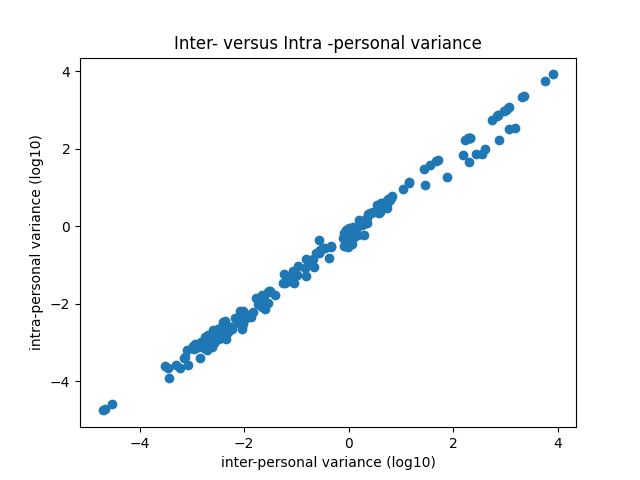

Text(0.5, 1.0, 'Inter- versus Intra -personal variance')

In [149]:
fig, ax = pylab.subplots()

ax.scatter(numpy.log10(total_var), numpy.log10(intra_personal))
ax.set_xlabel("inter-personal variance (log10)")
ax.set_ylabel("intra-personal variance (log10)")
ax.set_title("Inter- versus Intra -personal variance")

<IPython.core.display.Javascript object>


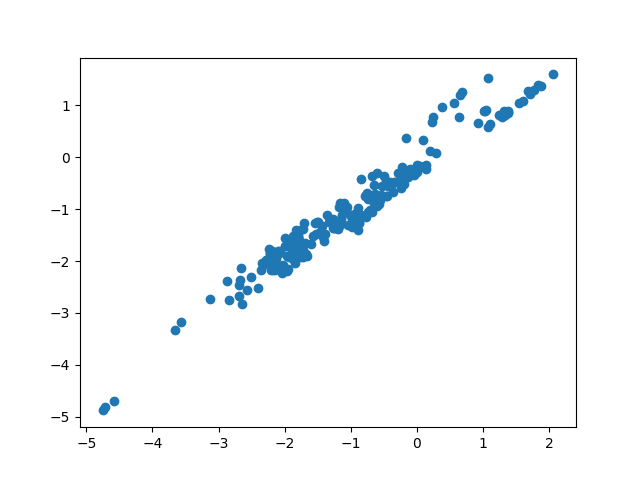

c:\users\tgb\appdata\local\programs\python\python36\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [150]:
# Intra- versus inter-personal variance normalized by mean value
fig, ax = pylab.subplots()

ax.scatter(numpy.log10((intra_personal / activity_seasonal.mean()).drop(index=["id", "instance"])),

           numpy.log10((inter_personal / activity_seasonal.mean()).drop(index=["id", "instance"]))
          )

<IPython.core.display.Javascript object>


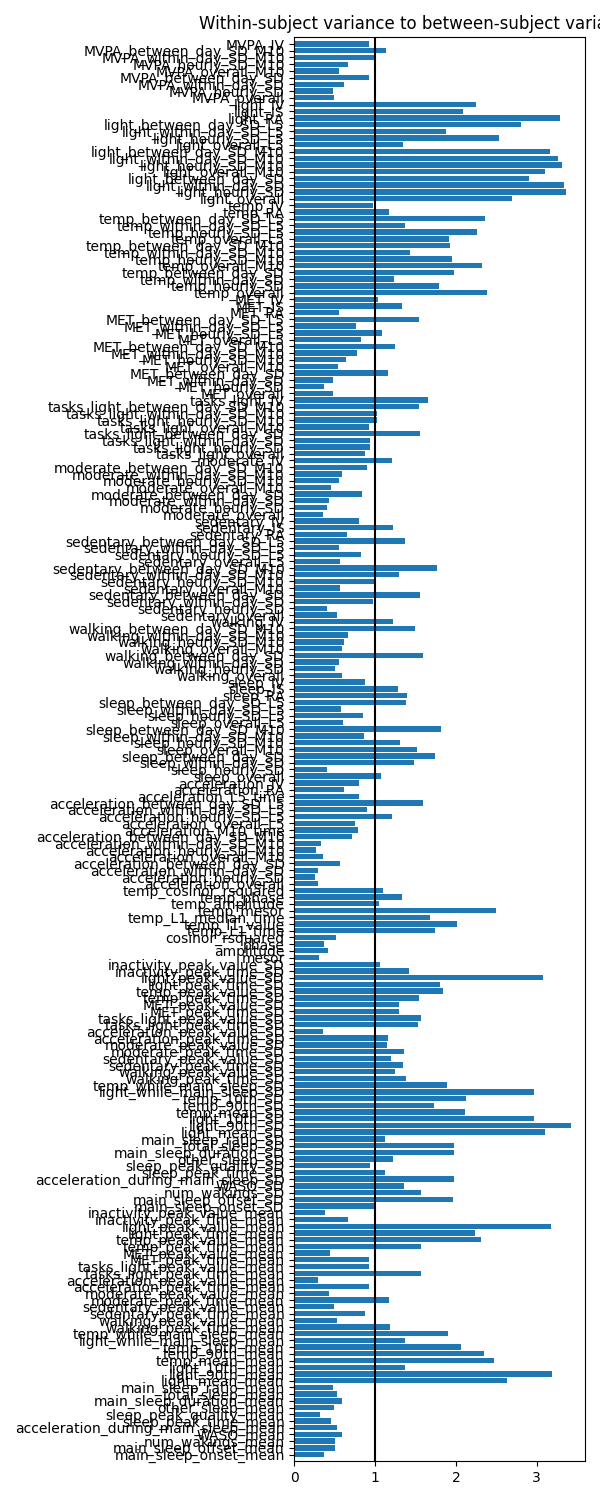

In [151]:
fig, ax = pylab.subplots(figsize=(6,15))
ax.barh(intra_personal_normalized.index, intra_personal_normalized, align="center",
        #xerr=intra_personal_normalized_errors*2
       )
ax.set_ylim(0-1, len(intra_personal_normalized))
#ax.set_xlim(0,1)
ax.set_title("Within-subject variance to between-subject variance ratio")
fig.tight_layout()
ax.axvline(1.0, c="k")

fig.savefig(OUTDIR+"activity_vars.fraction_within_variance.png")

In [152]:
intra_personal_normalized.shape

(211,)

### Summary Data

In [153]:
# Same but for the "summary" datas
summary_intra_personal = activity_summary_seasonal.groupby("id").var().mean()
summary_inter_personal = activity_summary_seasonal.groupby("id").mean().var()
summary_intra_personal_normalized = summary_intra_personal / summary_inter_personal

#summary_inter_personal = SSE(activity_summary_seasonal.groupby("id").mean())
#summary_intra_personal = activity_summary_seasonal.select_dtypes("number").groupby(activity_seasonal.id).apply(SSE)
#summary_total_var = SSE(activity_summary_seasonal.select_dtypes("number"))

#summary_intra_personal_normalized = summary_intra_personal / summary_total_var

In [154]:
pandas.DataFrame({"intra":summary_intra_personal, "inter":summary_inter_personal, "norm": summary_intra_personal_normalized})[summary_inter_personal.index.str.contains("overall")].head(30)

,intra,inter,norm
wearTime-overall(days),0.499493,0.236517,2.111871
nonWearTime-overall(days),0.367185,0.194819,1.884746
acc-overall-avg,15.863329,69.160662,0.229369
acc-overall-sd,107.212927,482.243584,0.222321
MVPA-overall-avg,0.000262,0.001177,0.222560
MVPA-overall-sd,0.000746,0.003735,0.199807
VPA-overall-avg,0.000005,0.000013,0.347037
VPA-overall-sd,0.000238,0.000792,0.299987
moderate-overall-avg,0.000395,0.001267,0.311819
moderate-overall-sd,0.001110,0.003442,0.322455


In [155]:
#summary_intra_personal_normalized[[c for c in summary_intra_personal_normalized.index if 'VPA-hourOfDay' in c]]#.sort_values().head(35)
#summary_intra_personal_normalized['acceleration-'].sort_values().head(150)
#fig, ax = pylab.subplots()
#ax.hist(summary_intra_personal_normalized)
summary_intra_personal_normalized.sort_values().head(50)

MVPA-overall-sd                   0.199807
acc-overall-sd                    0.222321
MVPA-overall-avg                  0.222560
acc-overall-avg                   0.229369
MVPA-weekday-avg                  0.248654
acc-weekday-avg                   0.258489
sleep-hourOfDay-23-avg            0.275309
MVPA-hourOfWeekday-6-avg          0.299777
VPA-overall-sd                    0.299987
sleep-hourOfWeekday-23-avg        0.301384
sedentary-hourOfDay-23-avg        0.302584
MVPA-hourOfDay-6-avg              0.308773
moderate-overall-avg              0.311819
sleep-hourOfDay-0-avg             0.316399
sedentary-overall-avg             0.321117
MVPA-hourOfDay-5-avg              0.321250
moderate-overall-sd               0.322455
MVPA-hourOfWeekday-5-avg          0.329124
sedentary-hourOfWeekday-23-avg    0.333370
sedentary-hourOfDay-0-avg         0.334258
moderate-weekday-avg              0.334476
MET-overall-sd                    0.336282
sedentary-weekday-avg             0.337026
MET-hourOfD

<IPython.core.display.Javascript object>


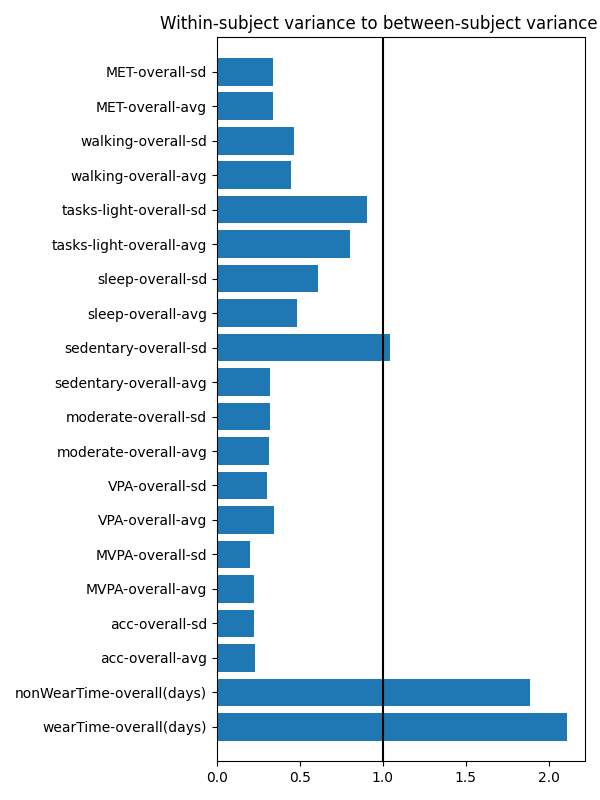

In [156]:
# Show same for the "summary" data
fig, ax = pylab.subplots(figsize=(6,8))
summary_vals_to_use = summary_intra_personal[summary_intra_personal.index.str.contains("overall")].index
ax.barh(summary_intra_personal_normalized.loc[summary_vals_to_use].index,
        summary_intra_personal_normalized.loc[summary_vals_to_use],
        align="center")
ax.set_ylim(0-1, len(summary_vals_to_use))
ax.axvline(1.0, c="k")
#ax.set_xlim(0,1)
ax.set_title("Within-subject variance to between-subject variance ratio")
fig.tight_layout()

fig.savefig(OUTDIR+"summary_vars.fraction_within_variance.png")

<IPython.core.display.Javascript object>


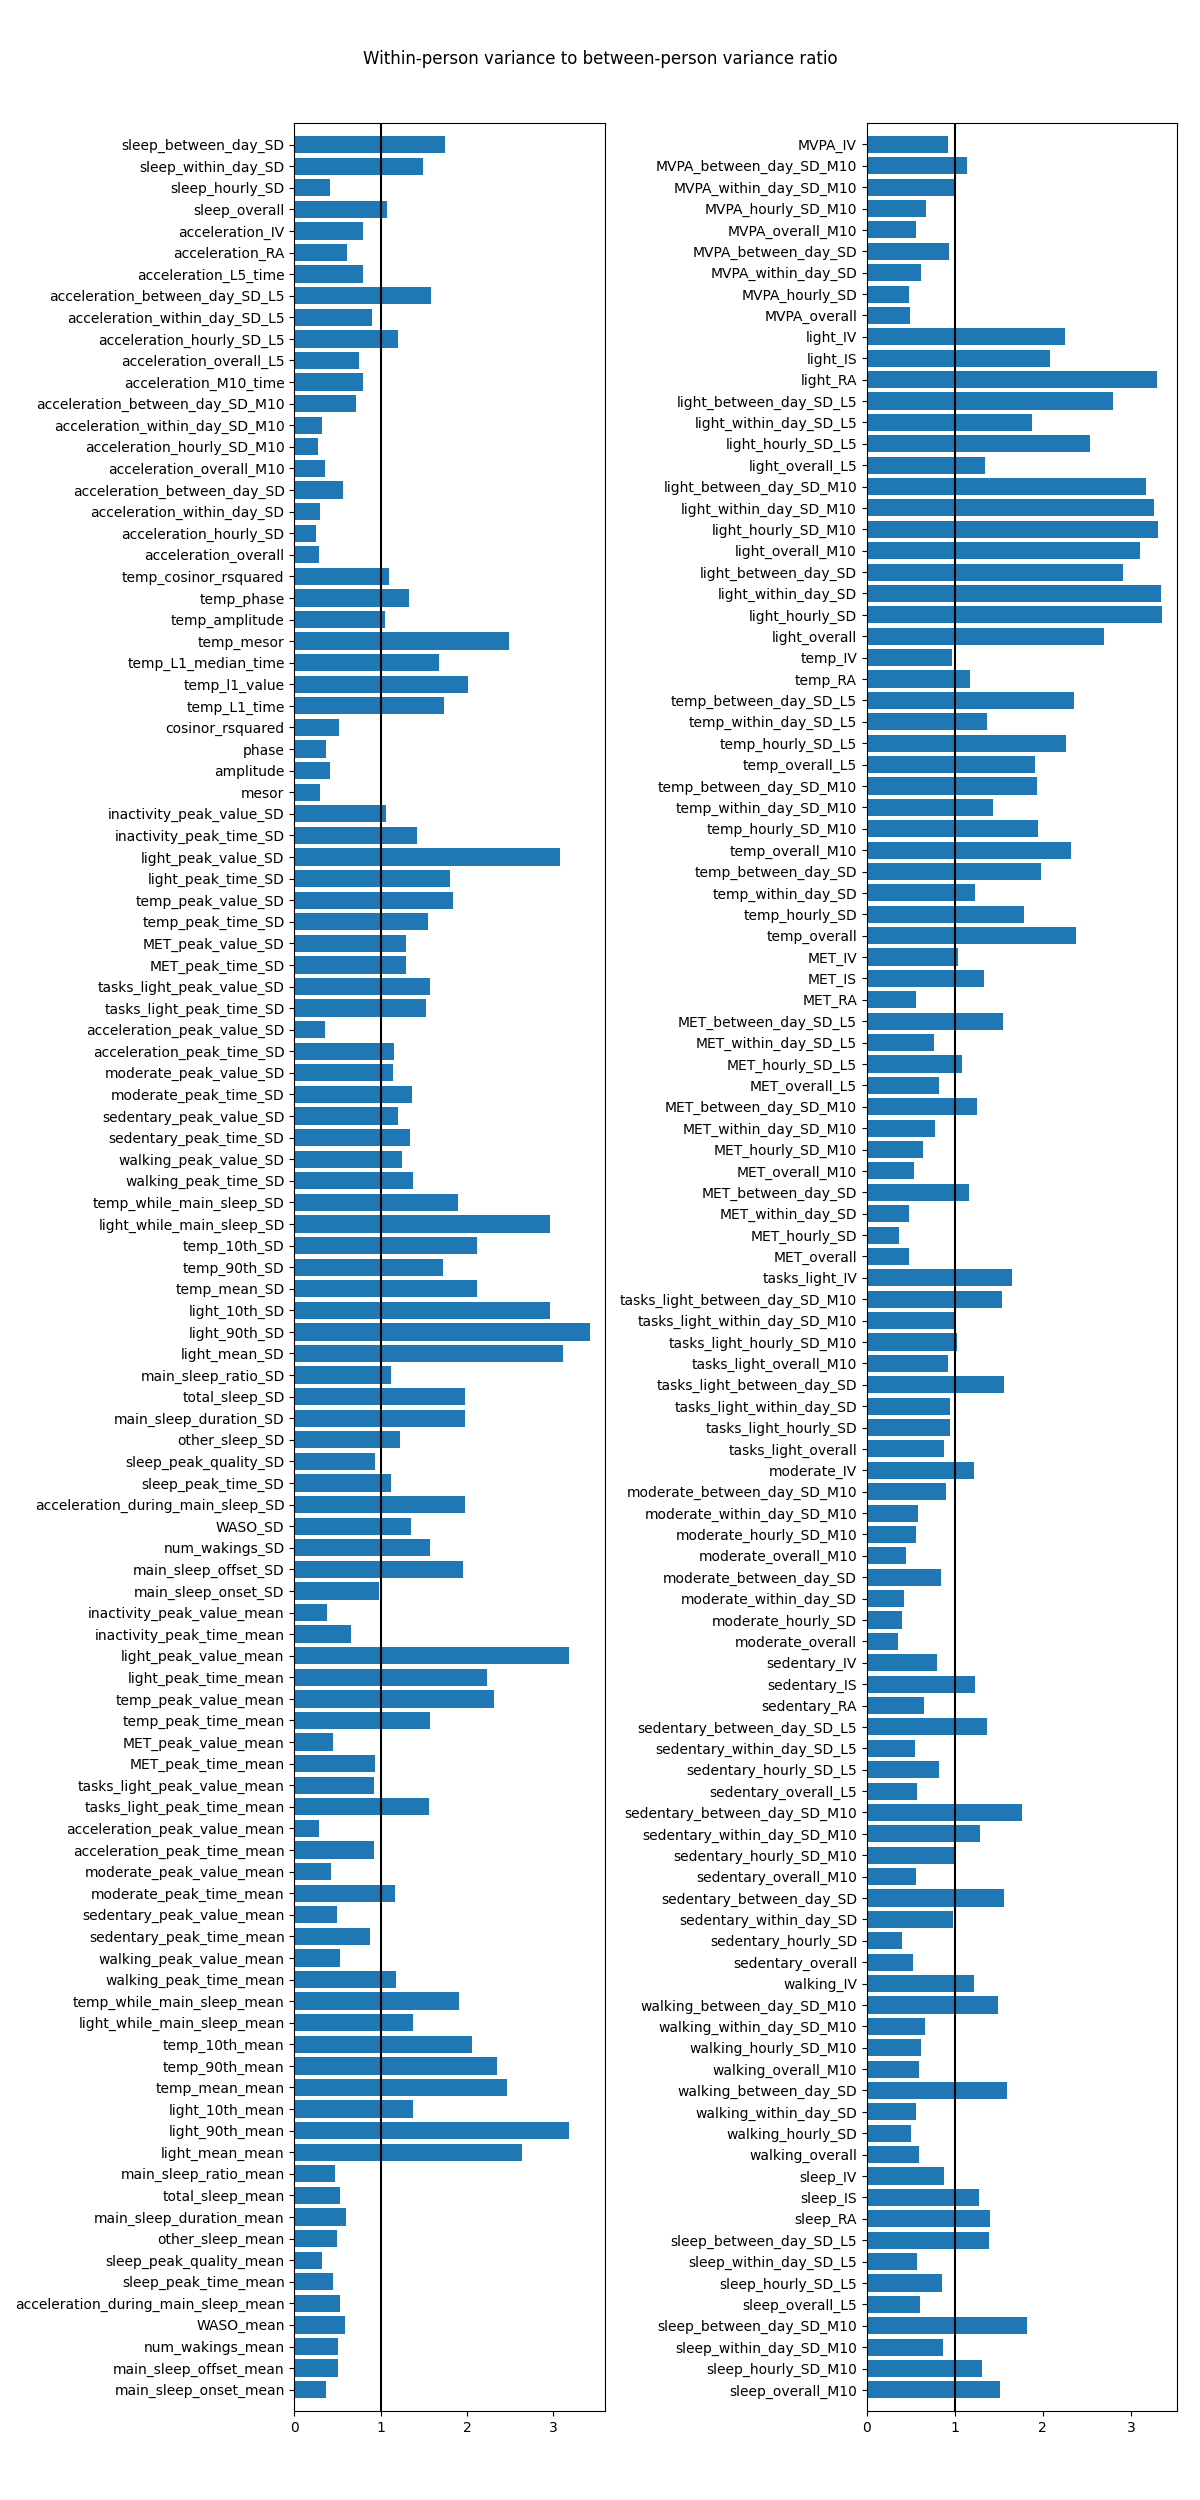

95 out of 211 variables pass variance test


In [157]:
fig, axes = pylab.subplots(figsize=(12,25), ncols=2)
tests_all = pandas.concat([intra_personal_normalized,
                           #summary_intra_personal_normalized[summary_vals_to_use]
                          ], axis=0)
for ax, tests in zip( axes,
                     [tests_all[:len(tests_all)//2],
                       tests_all[len(tests_all)//2:]]):
    ax.barh(tests.index, tests, align="center",
            #xerr=intra_personal_normalized_errors*2
           )
    ax.set_ylim(0-1, len(tests))
    #ax.set_xlim(0,1)
    ax.axvline(1.0, c="k")

fig.suptitle("Within-person variance to between-person variance ratio")
fig.tight_layout(rect=[0,0.02, 1, 0.97])
fig.savefig(OUTDIR+"all_activity_vars.fraction_within_variance.png")
print(f"{(tests_all < 1).sum()} out of {len(tests_all)} variables pass variance test")

In [158]:
# save the measures out
inter_intra_variance = pandas.concat([
    pandas.DataFrame({
        "inter": inter_personal,
        "intra": intra_personal,
        "normalized": intra_personal_normalized
    }),
    pandas.DataFrame({
        "inter": summary_inter_personal,
        "intra": summary_intra_personal,
        "normalized": summary_intra_personal_normalized
    })])
inter_intra_variance.to_csv("../processed/inter_intra_personal_variance.txt", sep="\t")

In [159]:
activity_seasonal.sleep_overall.describe()

count    10061.000000
mean         0.388204
std          0.065610
min          0.114907
25%          0.347154
50%          0.382385
75%          0.420058
max          0.734708
Name: sleep_overall, dtype: float64

In [160]:
## Check for normality
scipy.stats.normaltest((activity["main_sleep_duration_std"]), nan_policy="omit")

NormaltestResult(statistic=95737.91240688048, pvalue=0.0)

### Seasonality

In [161]:
activity_seasonal['start_date'] = pandas.to_datetime(activity_summary_seasonal['file-startTime'])
year_start = pandas.to_datetime(activity_seasonal.start_date.dt.year.astype(str) + "-01-01")
activity_seasonal['year_fraction'] = (activity_seasonal.start_date - year_start) / (pandas.to_timedelta("1Y"))
activity_seasonal['cos_year_fraction'] = numpy.cos(activity_seasonal.year_fraction*2*numpy.pi)
activity_seasonal['sin_year_fraction'] = numpy.sin(activity_seasonal.year_fraction*2*numpy.pi)

In [162]:
def cyclic_lowess(y, x, **kwargs):
    cyclic_x = numpy.concatenate([x-1, x, x+1])
    cyclic_y = numpy.concatenate([y, y, y])
    return sm.nonparametric.lowess(cyclic_y, cyclic_x, **kwargs)

<IPython.core.display.Javascript object>


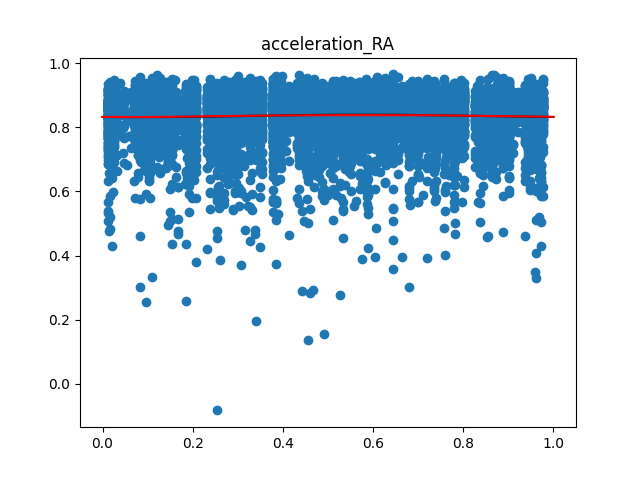

<IPython.core.display.Javascript object>


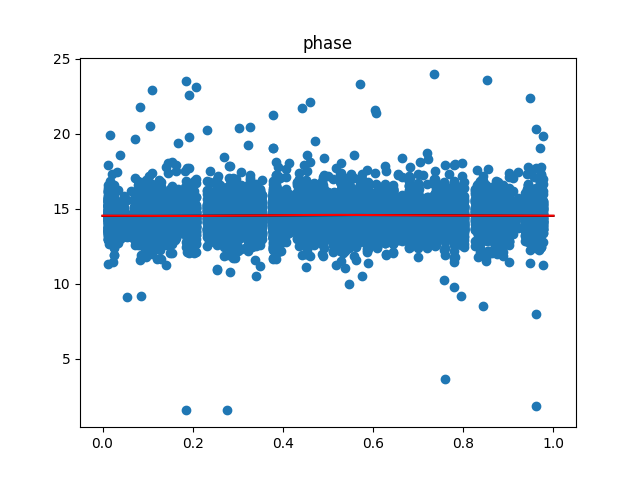

<IPython.core.display.Javascript object>


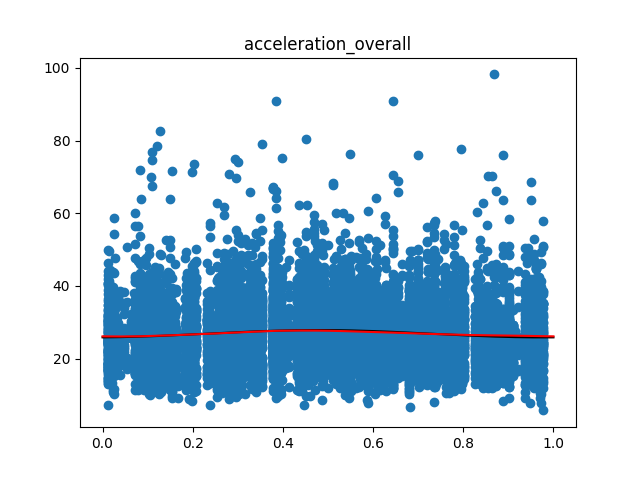

<IPython.core.display.Javascript object>


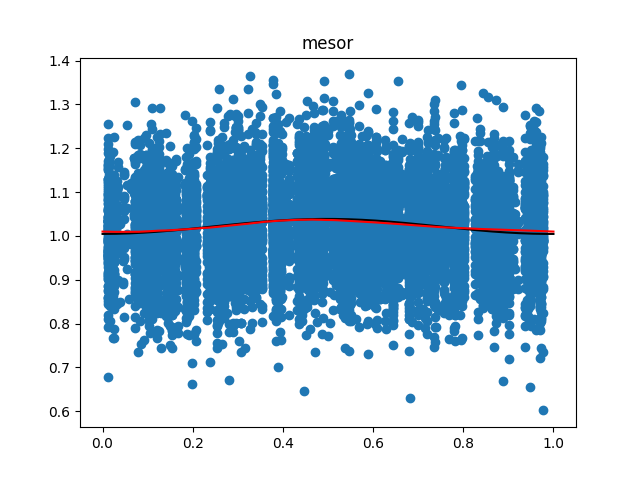

In [163]:
for activity_var in ["acceleration_RA", "phase", "acceleration_overall", "mesor"]:
    results = smf.ols(f"{activity_var} ~ cos_year_fraction + sin_year_fraction", data = activity_seasonal).fit()
    fig, ax = pylab.subplots()
    ax.scatter(activity_seasonal.year_fraction, activity_seasonal[activity_var])
    t = numpy.linspace(0, 1, 201)
    lowess = cyclic_lowess(activity_seasonal[activity_var], activity_seasonal.year_fraction, it = 0, frac=0.2, xvals=t)
    ax.plot(t, results.params['Intercept'] + results.params['cos_year_fraction'] * numpy.cos(t * numpy.pi * 2) + results.params['sin_year_fraction'] * numpy.sin(t * numpy.pi * 2), c='k')
    ax.plot(t, lowess, c='r')
    ax.set_title(activity_var)

In [164]:
# Run the cosinor fits for all the features throughout the year
# and "correct" for the seasonal component
seasonal_tests_data = []
def circvar_ddof(series):
    if (len(series) - DDOF) == 0:
        return float("NaN")
    return scipy.stats.circvar(series, nan_policy="omit", high=24) * len(series) / (len(series) - DDOF)
for activity_var in activity_seasonal.select_dtypes(['number']).columns:
    results = smf.ols(f"{activity_var} ~ cos_year_fraction + sin_year_fraction", data=activity_seasonal).fit()
    corrected = activity_seasonal[activity_var] - results.predict(activity_seasonal)
    if activity_var in phase_variables:
        corrected_inter_personal = scipy.stats.circvar(corrected.groupby(activity_seasonal.id).apply(scipy.stats.circmean, nan_policy="omit", high=24), nan_policy="omit", high=24)
        corrected_intra_personal = corrected.groupby(activity_seasonal.id).apply(circvar_ddof).mean()
#inter_personal[phase_variables] = circvar(groupby_apply(activity_seasonal[phase_variables].groupby(activity_seasonal.id), circmean))
#intra_personal[phase_variables] = (groupby_apply(activity_seasonal[phase_variables].groupby(activity_seasonal.id), circvar)).mean()

    else:
        corrected_inter_personal = corrected.groupby(activity_seasonal.id).mean().var()
        corrected_intra_personal = corrected.groupby(activity_seasonal.id).var().mean()
    corrected_intra_normalized = corrected_intra_personal / corrected_inter_personal

    seasonal_tests_data.append({
        "activity_var": activity_var,
        "p": results.f_pvalue,
        "cos": results.params['cos_year_fraction'],
        "sin": results.params['sin_year_fraction'],
        "corrected_inter_personal": corrected_inter_personal,
        "corrected_intra_personal": corrected_intra_personal,
        "corrected_intra_personal_normalized": corrected_intra_normalized,
    })
seasonal_tests = pandas.DataFrame(seasonal_tests_data)

In [165]:
seasonal_tests['amplitude'] = numpy.sqrt(seasonal_tests.cos**2 + seasonal_tests.sin**2)
seasonal_tests['inter_personal_std'] = numpy.sqrt(seasonal_tests.activity_var.map(inter_personal))
seasonal_tests['std_amplitude'] = seasonal_tests.amplitude / seasonal_tests.inter_personal_std
seasonal_tests['intra_personal_normalized'] = seasonal_tests.activity_var.map(intra_personal_normalized)

In [166]:
seasonal_tests.sort_values(by="std_amplitude", ascending=False).head(50)

,activity_var,p,cos,sin,corrected_inter_personal,corrected_intra_personal,corrected_intra_personal_normalized,amplitude,inter_personal_std,std_amplitude,intra_personal_normalized
199,light_RA,0.000000e+00,-0.236109,0.009904,0.015031,0.022879,1.522099,0.236317,0.133852,1.765505,3.291265
188,light_hourly_SD,0.000000e+00,-29.746112,2.141347,264.867729,449.587928,1.697405,29.823088,17.511559,1.703052,3.358896
192,light_hourly_SD_M10,0.000000e+00,-32.133472,2.300388,312.094675,528.679312,1.693971,32.215708,19.071916,1.689170,3.306772
193,light_within_day_SD_M10,0.000000e+00,-24.581593,0.448664,182.285072,300.552279,1.648804,24.585687,14.579110,1.686364,3.258965
189,light_within_day_SD,0.000000e+00,-24.788309,1.258187,191.848301,328.731278,1.713496,24.820220,14.802245,1.676788,3.339186
34,light_peak_value_mean,0.000000e+00,-68.368416,3.343606,1580.544456,2691.303728,1.702770,68.450127,42.484313,1.611186,3.182205
12,light_90th_mean,0.000000e+00,-79.090682,6.186843,2341.514966,4181.174262,1.785671,79.332294,51.163009,1.550579,3.185737
191,light_overall_M10,0.000000e+00,-40.960549,2.423316,661.591587,1201.643546,1.816292,41.032171,27.241426,1.506242,3.099778
49,light_90th_SD,0.000000e+00,-37.094328,4.812004,550.504423,1229.283854,2.233014,37.405141,25.005226,1.495893,3.425805
194,light_between_day_SD_M10,0.000000e+00,-19.742188,2.870412,160.864390,307.176026,1.909534,19.949768,13.399058,1.488893,3.167430


In [175]:
set(seasonal_tests.activity_var[seasonal_tests.corrected_intra_personal_normalized < 1]).difference(res['Activity Variable'])

{'acceleration_M10_time', 'temp_amplitude', 'temp_cosinor_rsquared'}

In [168]:
seasonal_tests[seasonal_tests.activity_var.isin(phase_variables)]

,activity_var,p,cos,sin,corrected_inter_personal,corrected_intra_personal,corrected_intra_personal_normalized,amplitude,inter_personal_std,std_amplitude,intra_personal_normalized
0,main_sleep_onset_mean,2.383636e-01,0.005752,-0.025125,0.946808,0.342927,0.362192,0.025775,0.973128,0.026487,0.362758
1,main_sleep_offset_mean,1.068030e-20,0.147320,-0.036201,0.811390,0.397301,0.489655,0.151702,0.901976,0.168189,0.504434
5,sleep_peak_time_mean,4.366161e-08,0.070527,-0.030650,0.674851,0.299747,0.444168,0.076899,0.822064,0.093543,0.449246
19,walking_peak_time_mean,7.023324e-25,-0.274044,-0.060208,2.032407,2.350143,1.156335,0.280579,1.428432,0.196425,1.177702
21,sedentary_peak_time_mean,3.704159e-07,0.177139,-0.011295,3.460435,3.029249,0.875395,0.177499,1.861242,0.095366,0.880221
23,moderate_peak_time_mean,3.281070e-01,-0.014733,0.042086,2.601817,3.048369,1.171631,0.044590,1.613507,0.027635,1.170989
25,acceleration_peak_time_mean,1.552814e-16,-0.230842,-0.031212,2.325362,2.114562,0.909347,0.232943,1.527456,0.152504,0.919848
27,tasks_light_peak_time_mean,2.779581e-02,-0.075683,-0.031528,2.416146,3.763743,1.557747,0.081988,1.554181,0.052753,1.562094
29,MET_peak_time_mean,5.024859e-05,-0.124891,-0.016659,2.507830,2.323034,0.926312,0.125997,1.584321,0.079528,0.929720
31,temp_peak_time_mean,7.594691e-14,-0.368460,-0.023603,5.922377,9.147442,1.544556,0.369215,2.436545,0.151532,1.573019


<IPython.core.display.Javascript object>


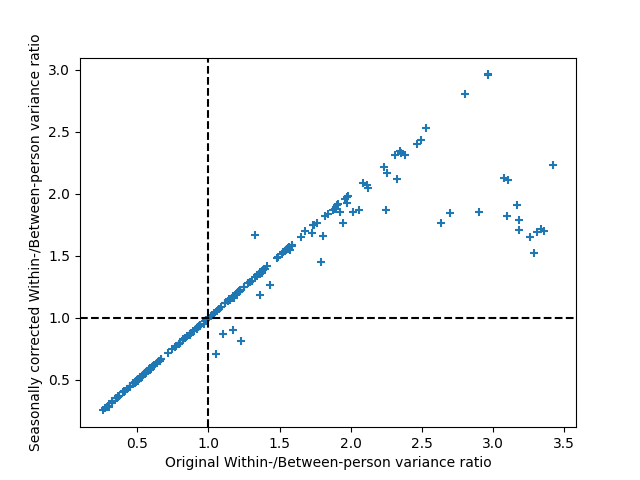

In [173]:
fig, ax = pylab.subplots()
ax.scatter(seasonal_tests.intra_personal_normalized, seasonal_tests.corrected_intra_personal_normalized, marker="+")
ax.axhline(1, c="k", linestyle="--")
ax.axvline(1, c="k", linestyle="--")
ax.set_xlabel("Original Within-/Between-person variance ratio")
ax.set_ylabel("Seasonally corrected Within-/Between-person variance ratio")
fig.savefig(OUTDIR+"seasonal_correction.png")

In [178]:
print(f"Variables which pass controls after correcting for seasonality:")
seasonal_tests.query("corrected_intra_personal_normalized < 1 and intra_personal_normalized > 1")

Variables which pass controls after correcting for seasonality:


,activity_var,p,cos,sin,corrected_inter_personal,corrected_intra_personal,corrected_intra_personal_normalized,amplitude,inter_personal_std,std_amplitude,intra_personal_normalized,difference
82,temp_amplitude,0.000000e+00,0.544103,0.103708,0.523525,0.372093,0.710747,0.553899,0.738315,0.750220,1.052669,0.341922
84,temp_cosinor_rsquared,1.410689e-256,0.073578,-0.001283,0.013724,0.011903,0.867293,0.073589,0.118631,0.620319,1.102225,0.234932
175,temp_within_day_SD,0.000000e+00,0.396185,0.124426,0.238483,0.194339,0.814897,0.415264,0.500445,0.829789,1.232251,0.417354
185,temp_RA,1.047551e-315,-0.017550,-0.003998,0.000650,0.000585,0.899282,0.017999,0.026047,0.691043,1.171970,0.272688


In [179]:
seasonal_tests.to_csv("../processed/inter_intra_personal_variance.seasonal_correction.txt", sep="\t", index=False)

In [180]:
print(f"Biggest changes in variables due to seasonal corrections:")
seasonal_tests['difference'] =  (seasonal_tests.corrected_intra_personal_normalized - seasonal_tests.intra_personal_normalized).abs()
seasonal_tests.sort_values('difference', ascending=False).head(40)

Biggest changes in variables due to seasonal corrections:


,activity_var,p,cos,sin,corrected_inter_personal,corrected_intra_personal,corrected_intra_personal_normalized,amplitude,inter_personal_std,std_amplitude,intra_personal_normalized,difference
199,light_RA,0.000000e+00,-0.236109,0.009904,0.015031,0.022879,1.522099,0.236317,0.133852,1.765505,3.291265,1.769166
188,light_hourly_SD,0.000000e+00,-29.746112,2.141347,264.867729,449.587928,1.697405,29.823088,17.511559,1.703052,3.358896,1.661491
189,light_within_day_SD,0.000000e+00,-24.788309,1.258187,191.848301,328.731278,1.713496,24.820220,14.802245,1.676788,3.339186,1.625690
192,light_hourly_SD_M10,0.000000e+00,-32.133472,2.300388,312.094675,528.679312,1.693971,32.215708,19.071916,1.689170,3.306772,1.612801
193,light_within_day_SD_M10,0.000000e+00,-24.581593,0.448664,182.285072,300.552279,1.648804,24.585687,14.579110,1.686364,3.258965,1.610162
34,light_peak_value_mean,0.000000e+00,-68.368416,3.343606,1580.544456,2691.303728,1.702770,68.450127,42.484313,1.611186,3.182205,1.479435
12,light_90th_mean,0.000000e+00,-79.090682,6.186843,2341.514966,4181.174262,1.785671,79.332294,51.163009,1.550579,3.185737,1.400066
191,light_overall_M10,0.000000e+00,-40.960549,2.423316,661.591587,1201.643546,1.816292,41.032171,27.241426,1.506242,3.099778,1.283486
194,light_between_day_SD_M10,0.000000e+00,-19.742188,2.870412,160.864390,307.176026,1.909534,19.949768,13.399058,1.488893,3.167430,1.257896
49,light_90th_SD,0.000000e+00,-37.094328,4.812004,550.504423,1229.283854,2.233014,37.405141,25.005226,1.495893,3.425805,1.192792
